In [ ]:
# Generate toy dataset
srand(238)

y = Vector{Float64}(n)
m_1_true = 4.0
w_1_true = 2.0
m_2_true = -4.0
w_2_true = 2.0

z_true = rand(n)
for i = 1:n
    if z_true[i] > 0.5
        y[i] = sqrt(1/w_1_true)*randn() + m_1_true
    else
        y[i] = sqrt(1/w_2_true)*randn() + m_2_true
    end
end

# Build

In [1]:
using ForneyLab

n = 20

g = FactorGraph()

# Specify model
m_1 ~ GaussianMeanVariance(constant(5.0), constant(100.0))
w_1 ~ Gamma(constant(0.01), constant(0.01))
m_2 ~ GaussianMeanVariance(constant(-5.0), constant(100.0))
w_2 ~ Gamma(constant(0.01), constant(0.01))

z = Vector{Variable}(n)
for i = 1:n
    z[i] ~ Bernoulli(constant(0.5))
    y_i ~ GaussianMixture(z[i], m_1, w_1, m_2, w_2)
    placeholder(y_i, :y, index=i)
    z[i].id = :z_*i
    y_i.id = :y_*i
end

# Assign ids for easy lookup
m_1.id = :m_1
w_1.id = :w_1
m_2.id = :m_2
w_2.id = :w_2
;

# Schedule

In [2]:
rf = RecognitionFactorization()

# Specify recognition factorization
q_m_1 = RecognitionFactor(m_1)
q_w_1 = RecognitionFactor(w_1)
q_m_2 = RecognitionFactor(m_2)
q_w_2 = RecognitionFactor(w_2)
q_z = RecognitionFactor(z)
;

In [3]:
# Generate Julia algorithm code
algo_q_m_1 = messagePassingAlgorithm(variationalSchedule(q_m_1), m_1, name="M1")
algo_q_w_1 = messagePassingAlgorithm(variationalSchedule(q_w_1), w_1, name="W1")
algo_q_m_2 = messagePassingAlgorithm(variationalSchedule(q_m_2), m_2, name="M2")
algo_q_w_2 = messagePassingAlgorithm(variationalSchedule(q_w_2), w_2, name="W2")
algo_q_z = messagePassingAlgorithm(variationalSchedule(q_z), z, name="Z")
algo_F = freeEnergyAlgorithm()
;

# Infer

In [4]:
# Load algorithms
eval(parse(algo_q_m_1))
eval(parse(algo_q_w_1))
eval(parse(algo_q_m_2))
eval(parse(algo_q_w_2))
eval(parse(algo_q_z))
eval(parse(algo_F))
;

In [5]:
data = Dict(:y => y)

# Prepare recognition distributions
marginals = Dict(:m_1 => vague(Gaussian),
                 :w_1 => vague(Gamma),
                 :m_2 => vague(Gaussian),
                 :w_2 => vague(Gamma))
for i = 1:n
    marginals[:z_*i] = vague(Bernoulli)
end

# Execute algorithm
n_its = 3*n
F = Vector{Float64}(n_its)
m_1_est = Vector{Float64}(n_its)
w_1_est = Vector{Float64}(n_its)
m_2_est = Vector{Float64}(n_its)
w_2_est = Vector{Float64}(n_its)
for i = 1:n_its
    stepM1!(data, marginals)
    stepW1!(data, marginals)
    stepM2!(data, marginals)
    stepW2!(data, marginals)
    stepZ!(data, marginals)
    
    F[i] = freeEnergy(data, marginals)
    m_1_est[i] = mean(marginals[:m_1])
    w_1_est[i] = mean(marginals[:w_1])
    m_2_est[i] = mean(marginals[:m_2])
    w_2_est[i] = mean(marginals[:w_2])
end

# Results

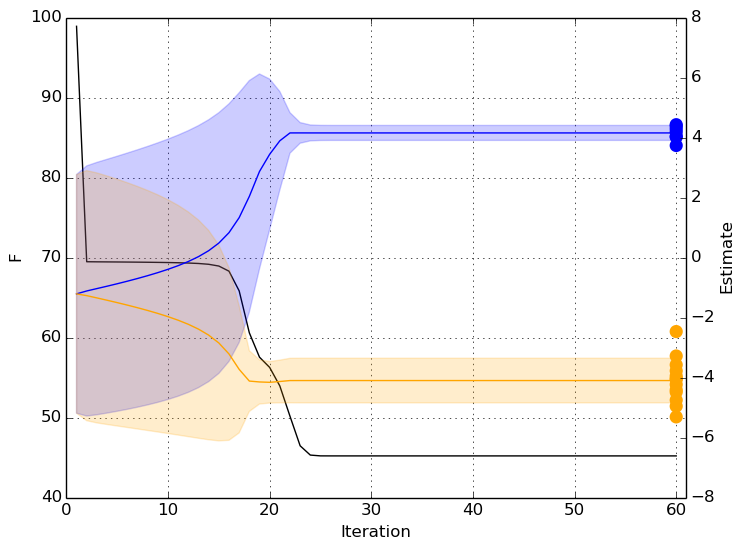

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


In [6]:
using PyPlot

# Plot free energy to check for convergence
plot(1:n_its, F, color="black")
grid("on")
xlabel("Iteration")
ylabel("F")

# Plot estimated distribution
PyPlot.plt[:twinx]()
plot(1:n_its, m_1_est, color="blue")
fill_between(1:n_its, m_1_est-sqrt(1.0./w_1_est), m_1_est+sqrt(1.0./w_1_est), color="blue", alpha=0.2)
plot(1:n_its, m_2_est, color="orange")
fill_between(1:n_its, m_2_est-sqrt(1.0./w_2_est), m_2_est+sqrt(1.0./w_2_est), color="orange", alpha=0.2)
ylabel("Estimate")

# Plot samples
scatter(n_its*ones(sum(z_true .> 0.5)), y[z_true .> 0.5], color="blue", linewidth=5)
scatter(n_its*ones(sum(z_true .<= 0.5)), y[z_true .<= 0.5], color="orange", linewidth=5)

xlim(0.0, n_its+1)
;

In [7]:
# Inspect the results
println("\n----- Estimates after $(n_its) VMP updates -----")
println("m_1 estimate: $(round(mean(marginals[:m_1]),2)), with variance $(round(var(marginals[:m_1]),2))")
println("w_1 estimate: $(round(mean(marginals[:w_1]),2)), with variance $(round(var(marginals[:w_1]),2))")
println("m_2 estimate: $(round(mean(marginals[:m_2]),2)), with variance $(round(var(marginals[:m_2]),2))")
println("w_2 estimate: $(round(mean(marginals[:w_2]),2)), with variance $(round(var(marginals[:w_2]),2))")


----- Estimates after 60 VMP updates -----
m_1 estimate: 4.15, with variance 0.01
w_1 estimate: 16.05, with variance 73.43
m_2 estimate: -4.1, with variance 0.04
w_2 estimate: 1.81, with variance 0.5
